<a href="https://colab.research.google.com/github/paulo-batista/puc-rio-ciencia-de-dados-e-analytics/blob/main/PUC_RIO_MVP_Final_PauloBatista.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**MVP - SPRINT II - MACHINE LEARNING & ANALYTICS**  

##**PARTE 1 - MACHINE LEARNING**

## **Título: Predição de Churn utilizando base da Olist**

**Objetivo:** A Olist é uma empresa de marketplace que tem como principal serviço alavancar a venda dos
seus clientes (que são vendedores) em plataformas de vendas online, como Amazon, Mercado Livre, Via Varejo, Americanas, Magazine Luiza etc.

A Olist quer identificar quais são os vendedores que terão uma maior dificuldade em realizar uma venda nos próximos 6 meses, ou seja, **o objetivo dessa analise é se antecipar e identificar quais os vendedores podem deixar de vender e com isso impactar negativamente o faturamento da Olist.**

A Olist disponibilizou dados históricos anonimizados durante o período de Janeiro de 2017 até Junho de 2018.

• Objetivo principal:
Quais vendedores não irão vender nos próximos 6 meses?
• Como resolver?
Construir um modelo de ML Supervisionado para prever quem não irá revender.
• Quais as fontes? Dados históricos de transações de venda

##Tabelas de transações Olist

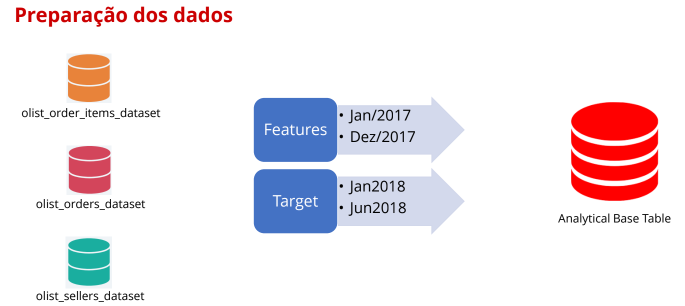

**Créditos** - Brazilian E-Commerce Public Dataset by Olist - https://www.kaggle.com/olistbr/brazilian-ecommerce

**Tabelas transacionais**  que serão utilizadas para análise:

**Olist_Orders** - Contém os pedidos de vendas

**Olist_Order_Items** - Contém as linhas de detalhes dos pedidos de venda

**Olist_Sellers**  - Vendedores (Clientes da Olist)



In [70]:
!pip install feature-engine
!pip install keras-preprocessing

In [71]:
# importing libs

# OS and files libs
import os
import gdown
import zipfile
import dateutil

# Dataset manipulation libs
import numpy as np
import pandas as pd

# Visualization lib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Data Manipulation libs
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay

# Machine Learning models libs
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Machine Learning Ensemble libs
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Deep Learning libs
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3


import warnings
warnings.filterwarnings('ignore')

### ML - Ingestão de dados, criação dos datasets Olist.


In [72]:
#Machine Learning - Olist Churn analysis
olist_dataset_url = 'https://drive.google.com/u/3/uc?id=1ebz-PKbAyXpyZQWdLzPL-dLUuj2z5EQo&export=download'

#Deep Learning - Classification
train_dataset_url = 'https://drive.google.com/u/3/uc?id=1_V2A4YySxyE56zEQd5BawxkD3oZnxJzA&export=download'
validation_dataset_url = 'https://drive.google.com/u/3/uc?id=18I1uKbkXvUIgLmhGeI9tU6mrLQ_V2NmT&export=download'
test_dataset_url = 'https://drive.google.com/u/3/uc?id=1fCPLV8_BFfvYlJmxdVZspRSnFamOfdEw&export=download'
model_inception_url = 'https://drive.google.com/u/3/uc?id=1nw4biA8rOv7k2h5NgiENhj6kFOZTJqoe&export=download'

# Download naming files
olist_output = 'olist.zip'
train_output = 'Training.zip'
validation_output = 'Validation.zip'
test_output = 'Test.zip'
model_inception = 'model_inception.h5'

#Downloading files
gdown.download(olist_dataset_url, olist_output, quiet=False)
gdown.download(train_dataset_url, train_output, quiet=False)
gdown.download(validation_dataset_url, validation_output, quiet=False)
gdown.download(test_dataset_url, test_output, quiet=False)
gdown.download(model_inception_url, model_inception, quiet=False)

# Zipped files naming
local_olist_zip = '/content/olist.zip'
local_train_zip =  '/content/Training.zip'
local_validation_zip =  '/content/Validation.zip'
local_test_zip = '/content/Test.zip'

# Unzipping files
zip_train = zipfile.ZipFile(local_olist_zip, 'r')
zip_train.extractall('tmp/olist')
zip_train.close()

zip_train = zipfile.ZipFile(local_train_zip, 'r')
zip_train.extractall('tmp/libras')
zip_train.close()

zip_validation = zipfile.ZipFile(local_validation_zip, 'r')
zip_validation.extractall('tmp/libras')
zip_validation.close()

zip_test = zipfile.ZipFile(local_test_zip, 'r')
zip_test.extractall('tmp/libras/Test')
zip_test.close()

Downloading...
From: https://drive.google.com/u/3/uc?id=1ebz-PKbAyXpyZQWdLzPL-dLUuj2z5EQo&export=download
To: /content/olist.zip
100%|██████████| 12.8M/12.8M [00:00<00:00, 126MB/s]
Downloading...
From: https://drive.google.com/u/3/uc?id=1_V2A4YySxyE56zEQd5BawxkD3oZnxJzA&export=download
To: /content/Training.zip
100%|██████████| 9.24M/9.24M [00:00<00:00, 82.0MB/s]
Downloading...
From: https://drive.google.com/u/3/uc?id=18I1uKbkXvUIgLmhGeI9tU6mrLQ_V2NmT&export=download
To: /content/Validation.zip
100%|██████████| 4.64M/4.64M [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/u/3/uc?id=1fCPLV8_BFfvYlJmxdVZspRSnFamOfdEw&export=download
To: /content/Test.zip
100%|██████████| 3.24k/3.24k [00:00<00:00, 14.4MB/s]
Downloading...
From: https://drive.google.com/u/3/uc?id=1nw4biA8rOv7k2h5NgiENhj6kFOZTJqoe&export=download
To: /content/model_inception.h5
100%|██████████| 87.9M/87.9M [00:00<00:00, 223MB/s]


In [73]:
# Loading Olist data

olist_base_dir = 'tmp/olist'
df_orders = pd.read_csv(os.path.join(olist_base_dir, 'olist_orders_dataset.csv'), parse_dates=['order_approved_at'])
df_order_items = pd.read_csv(os.path.join(olist_base_dir, 'olist_order_items_dataset.csv'))
df_sellers = pd.read_csv(os.path.join(olist_base_dir, 'olist_sellers_dataset.csv'))

In [74]:
df_sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [75]:
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [76]:
df_order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


### Construindo dataset analítico de treinamento e testes

In [77]:
df_abt_train = pd.DataFrame()
for safra in ['2018-01-01', '2018-02-01', '2018-03-01','2018-04-01','2018-05-01', '2018-06-01']:
    data_ref_safra     = pd.to_datetime(safra).date()
    data_inf_inclusiva = data_ref_safra - dateutil.relativedelta.relativedelta(months=12)
    data_sup_exclusiva = data_ref_safra + dateutil.relativedelta.relativedelta(months=6)
    #print(f"Data Ref: {data_ref_safra}; Data Inf: {data_inf_inclusiva}; Data Sup: {data_sup_exclusiva}")

    df_historico_abt = (
        df_order_items
        .merge(df_orders, on='order_id', how='inner')
        .query('order_status == "delivered"')
        .query(f'order_approved_at >= "{data_inf_inclusiva}" & order_approved_at < "{data_sup_exclusiva}"')
        .merge(df_sellers, on='seller_id', how='left')
    )

    df_features = (
        df_historico_abt
        .query(f'order_approved_at < "{data_ref_safra}"')
        .groupby('seller_id')
        .agg(uf                 = ('seller_state', 'first'),
             tot_orders_12m     = ('order_id', 'nunique'),
             tot_items_12m      = ('product_id', 'count'),
             tot_items_dist_12m = ('product_id', 'nunique'),
             receita_12m        = ('price', 'sum'),
             data_ult_vnd       = ('order_approved_at', 'max'))
        .reset_index()
        .assign(data_ref_safra = pd.to_datetime(f'{data_ref_safra}'))
        .assign(recencia = lambda df: (df['data_ref_safra'] - df['data_ult_vnd']).dt.days)
    )

    df_target = (
        df_historico_abt
        .query(f'order_approved_at >= "{data_ref_safra}" & order_approved_at < "{data_sup_exclusiva}"')
        .filter(['seller_id'])
        .drop_duplicates()
    )

    df_abt = (
        df_features
        .merge(df_target, how='left', on='seller_id', indicator=True)
        .assign(nao_revendeu_next_6m = lambda df: np.where(df['_merge'] == "left_only", 1, 0))
        .filter(['data_ref_safra', 'seller_id', 'uf', 'tot_orders_12m', 'tot_items_12m', 'tot_items_dist_12m', 'receita_12m', 'recencia', 'nao_revendeu_next_6m'])
    )
    if safra != '2018-06-01':
      df_abt_train = pd.concat([df_abt_train, df_abt])
    else:
      df_abt_test = df_abt

In [78]:
df_abt_train.head(3)

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_6m
0,2018-01-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,74,1
1,2018-01-01,001cca7ae9ae17fb1caed9dfb1094831,ES,171,207,9,21275.23,2,0
2,2018-01-01,002100f778ceb8431b7a1020ff7ab48f,SP,38,42,15,781.80,2,0


In [79]:
df_abt_train.tail(3)

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_6m
2101,2018-05-01,ffdd9f82b9a447f6f8d4b91554cc7dd3,PR,13,15,9,1790.50,6,0
2102,2018-05-01,ffeee66ac5d5a62fe688b9d26f83f534,SP,13,13,3,1709.87,61,0
2103,2018-05-01,fffd5413c0700ac820c7069d66d98c89,SP,41,42,24,6242.90,2,0


In [80]:
df_abt_test.head(3)

,data_ref_safra,seller_id,uf,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,nao_revendeu_next_6m
0,2018-06-01,0015a82c2db000af6aaaf3ae2ecb0532,SP,3,3,1,2685.00,225,1
1,2018-06-01,001cca7ae9ae17fb1caed9dfb1094831,ES,140,162,10,16992.34,33,0
2,2018-06-01,002100f778ceb8431b7a1020ff7ab48f,SP,50,54,24,1216.60,49,1


In [81]:
df_abt_train.shape, df_abt_test.shape

((9414, 9), (2213, 9))

### Utilizando as bases análiticas, inicio o estudos dos modelos de ML que terá malhor acuracidade para resolver a questao: Quais vendedores não irão vender nos próximos 6 meses?



In [82]:
# Variáveis chaves da tabela
key_vars = ['data_ref_safra', 'seller_id']

# Variáveis numéricas
num_vars = ['tot_orders_12m',	'tot_items_12m',	'tot_items_dist_12m',	'receita_12m',	'recencia']

# Variáveis categóricas
cat_vars = ['uf']

# Variável resposta/target
target = 'nao_revendeu_next_6m'

# criando a lista com as features
features = num_vars + cat_vars

# Filtrando a base de features
X_train = pd.DataFrame(df_abt_train[features])
X_test = pd.DataFrame(df_abt_train[features])
# Filtrando o target
y_train = pd.DataFrame(df_abt_train[target])
y_test = pd.DataFrame(df_abt_test[target])

### Feature engineering

In [83]:
# Feature - Cleaning data
pd.options.mode.chained_assignment='raise'

X_train[cat_vars] = X_train[cat_vars].fillna('missing')
X_test[cat_vars]  = X_test[cat_vars].fillna('missing')

In [84]:
# Feature - Scaling
scaler = StandardScaler()
scaler.fit(X_train[num_vars])

X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_vars]), columns=num_vars)
X_train_scaled.head(3)

,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia
0,-0.311214,-0.314979,-0.443559,-0.105671,-0.006885
1,1.697043,1.846302,-0.076738,1.528174,-0.759101
2,0.107173,0.098207,0.198378,-0.272938,-0.759101


In [85]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test[num_vars]), columns=num_vars)
X_test_scaled.head(3)

,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia
0,-0.311214,-0.314979,-0.443559,-0.105671,-0.006885
1,1.697043,1.846302,-0.076738,1.528174,-0.759101
2,0.107173,0.098207,0.198378,-0.272938,-0.759101


In [86]:
# Feature - Categorical var treatments
ohe = OneHotEncoder(variables=cat_vars)
X_train_cat_ohe = ohe.fit_transform(X_train[cat_vars])
X_test_cat_ohe  = ohe.transform(X_test[cat_vars])
X_train_cat_ohe.head(3)

,uf_SP,uf_ES,uf_GO,uf_PR,uf_MG,uf_RN,uf_SC,uf_RJ,uf_RS,uf_PB,...,uf_MT,uf_AM,uf_RO,uf_CE,uf_BA,uf_SE,uf_MS,uf_PA,uf_MA,uf_PI
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
# realinhando os índices das tabelas
X_train_scaled = X_train_scaled.set_index(X_train.index)
X_test_scaled  = X_test_scaled.set_index(X_test.index)

X_train_cat_ohe = X_train_cat_ohe.set_index(X_train.index)
X_test_cat_ohe = X_test_cat_ohe.set_index(X_test.index)

X_train_transformed = pd.concat([X_train_scaled, X_train_cat_ohe], axis='columns')
X_train_transformed.head(3)

,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,uf_SP,uf_ES,uf_GO,uf_PR,uf_MG,...,uf_MT,uf_AM,uf_RO,uf_CE,uf_BA,uf_SE,uf_MS,uf_PA,uf_MA,uf_PI
0,-0.311214,-0.314979,-0.443559,-0.105671,-0.006885,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.697043,1.846302,-0.076738,1.528174,-0.759101,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.107173,0.098207,0.198378,-0.272938,-0.759101,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
X_test_transformed = pd.concat([X_test_scaled, X_test_cat_ohe], axis='columns')
X_test_transformed.head(3)

,tot_orders_12m,tot_items_12m,tot_items_dist_12m,receita_12m,recencia,uf_SP,uf_ES,uf_GO,uf_PR,uf_MG,...,uf_MT,uf_AM,uf_RO,uf_CE,uf_BA,uf_SE,uf_MS,uf_PA,uf_MA,uf_PI
0,-0.311214,-0.314979,-0.443559,-0.105671,-0.006885,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.697043,1.846302,-0.076738,1.528174,-0.759101,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.107173,0.098207,0.198378,-0.272938,-0.759101,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
lr_model_pipe = Pipeline(steps=[
                ('numeric_imputer', MeanMedianImputer(variables=num_vars, imputation_method='median')),
                ('numeric_scaler', SklearnTransformerWrapper(variables=num_vars, transformer=StandardScaler())),
                ('categoric_imputer', CategoricalImputer(variables=cat_vars, fill_value='missing')),
                ('one_hot_encoder', OneHotEncoder(variables=cat_vars)),
                ('model', LogisticRegression(random_state=42))
])

## Baseline

LR: 0.826957 (0.013276)
KNN: 0.823451 (0.011416)
CART: 0.771298 (0.012501)
NB: 0.500637 (0.012694)
SVM: 0.834180 (0.014408)
Bagging: 0.826108 (0.014583)
RF: 0.873698 (0.010940)
ET: 0.871996 (0.009860)
Ada: 0.829401 (0.015930)
GB: 0.840873 (0.013016)
Voting: 0.831525 (0.014382)


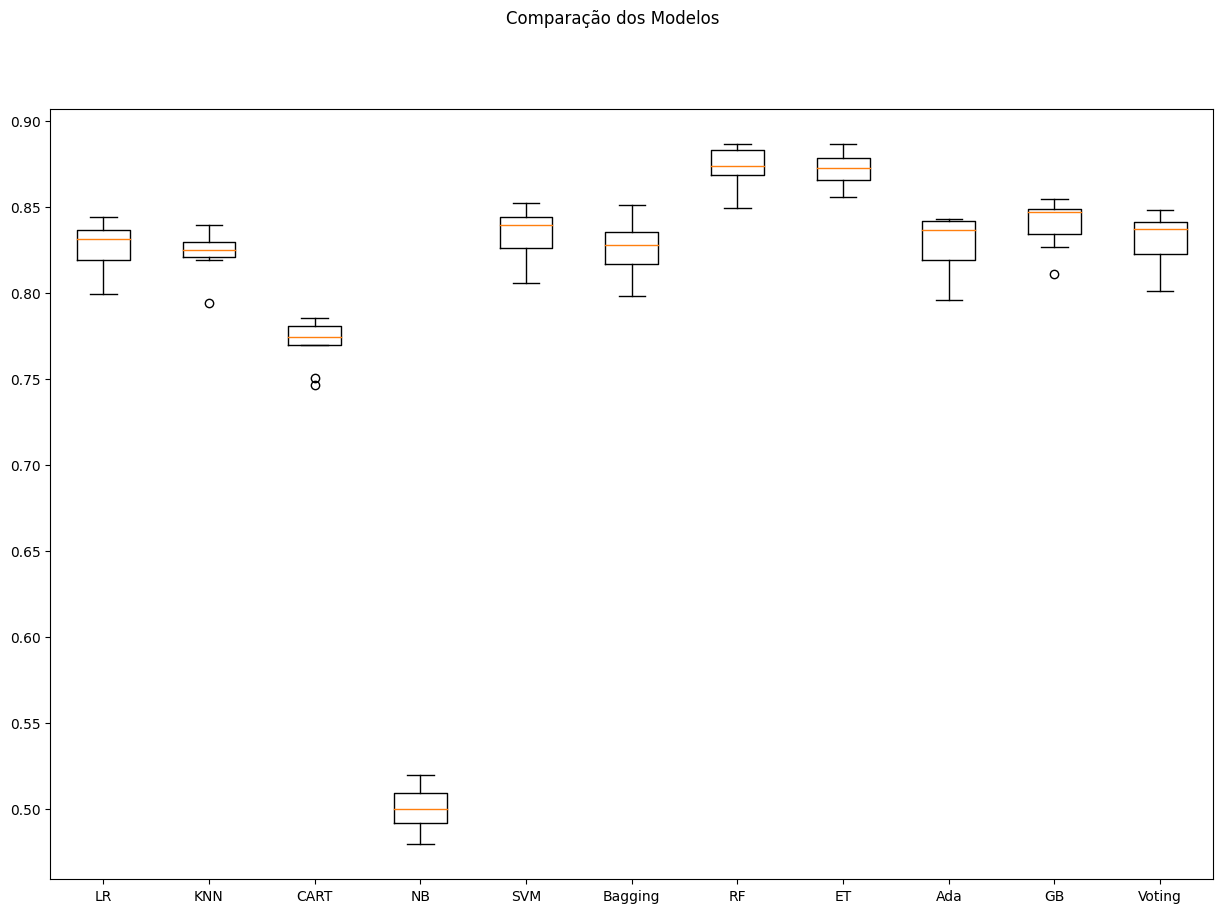

In [90]:
scoring = 'accuracy'
seed = 42
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

np.random.seed(42) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train_transformed, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Baseado no resultado inicial, a **melhor performance ocorreu com o modelo ExtraTree** com acuracidade: **0.871996 (0.009860)**

LR-orig: 0.827 (0.013)
KNN-orig: 0.823 (0.011)
CART-orig: 0.769 (0.014)
NB-orig: 0.501 (0.013)
SVM-orig: 0.834 (0.014)
Bag-orig: 0.826 (0.014)
RF-orig: 0.874 (0.012)
ET-orig: 0.871 (0.010)
Ada-orig: 0.829 (0.016)
GB-orig: 0.841 (0.013)
Vot-orig: 0.831 (0.014)
LR-padr: 0.826 (0.014)
KNN-padr: 0.823 (0.012)
CART-padr: 0.768 (0.014)
NB-padr: 0.485 (0.011)
SVM-padr: 0.828 (0.014)
Bag-padr: 0.824 (0.011)
RF-padr: 0.874 (0.011)
ET-padr: 0.873 (0.009)
Ada-padr: 0.829 (0.016)
GB-padr: 0.840 (0.014)
Vot-padr: 0.828 (0.015)
LR-norm: 0.826 (0.013)
KNN-norm: 0.821 (0.014)
CART-norm: 0.769 (0.018)
NB-norm: 0.497 (0.011)
SVM-norm: 0.829 (0.014)
Bag-norm: 0.826 (0.012)
RF-norm: 0.872 (0.010)
ET-norm: 0.873 (0.010)
Ada-norm: 0.829 (0.016)
GB-norm: 0.841 (0.013)
Vot-norm: 0.829 (0.015)


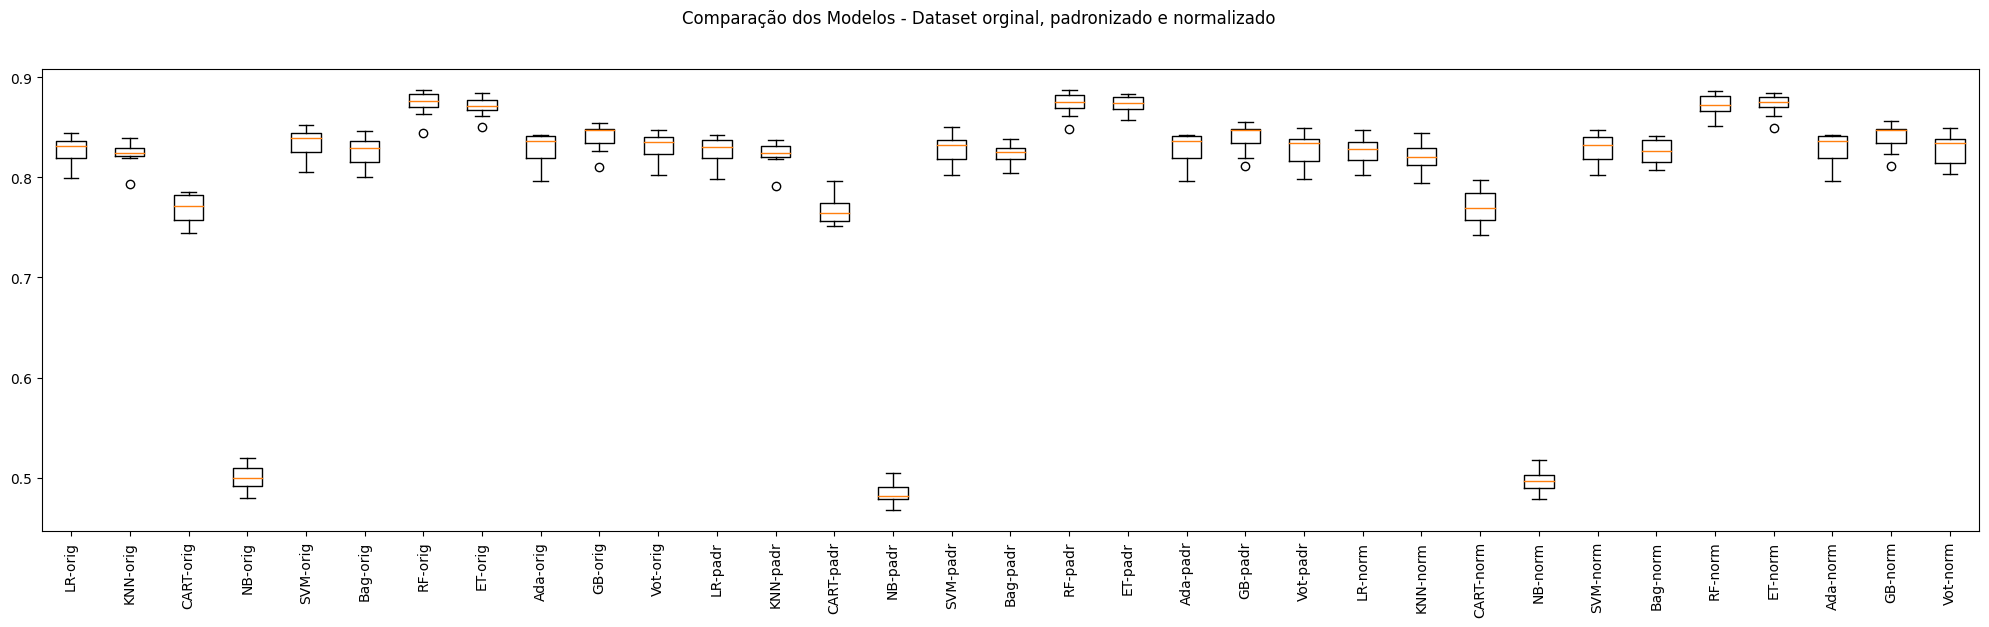

In [91]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train_transformed, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### **Random Forest Padrão** mostrou-se com **melhor desempenho:** 0.874 (0.011)

##**PARTE 2 - DEEP LEARNING**

Na segunda parte deste trabalho será desenvolvido um modelo de Aprendizagem Profunda na áreas de Visão Computacional, para reconhecimento de LIBRAS.

LIBRAS é a sigla de Língua Brasileira de Sinais, um conjunto de formas gestuais utilizado por deficientes auditivos para a comunicação entre eles e outras pessoas, sejam elas surdas ou ouvintes.

Objetivo: Reconhecimento de imagens contendo LIBRAS, transcrevendo seu significado.

In [92]:
# Mapeamento das unidades de arquivos requeridas
base_dir = 'tmp/libras/Training'
casa_dir = os.path.join(base_dir, 'Casa')
test_dir = 'tmp/libras/Test'

fname = '0.PNG'
libras_casa = os.path.join(casa_dir, fname)
img = mpimg.imread(libras_casa)


Aqui apresento um exemplo de sinal "Casa" em LIBRAS.

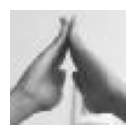

In [93]:
plt.figure(figsize=(1.5,1.5))
plt.imshow(img)
plt.axis('Off')
plt.show()

Para desenvolvimento de reconhecimento de LIBRAS, optei pelo uso de Redes Neurais Convolucionais, utilizando técnicas de pooling, augmentation e droupout.

In [94]:
# Creating Keras/Tensorflow Model

def create_model():
    model = tf.keras.models.Sequential()

    # Camadas de convolução e pooling
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(75, 75, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Camada densamente conectada
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.25))

    # Camada de saída
    model.add(tf.keras.layers.Dense(40, activation='softmax'))  # Usando softmax para classificação multiclasse

    return model

model = create_model()

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Visualizar o resumo do modelo
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_192 (Conv2D)         (None, 73, 73, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 36, 36, 32)        0         
                                                                 
 conv2d_193 (Conv2D)         (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 17, 17, 64)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 17, 17, 64)       

In [95]:
# Set the training parameters
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [109]:
TRAINING_DIR = base_dir

#Coding augmentation with ImageDataGenerator

training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/libras/Validation"

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(75,75),
	class_mode='categorical',
  batch_size=20
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(75,75),
	class_mode='categorical',
  batch_size=20
)

Found 3179 images belonging to 40 classes.
Found 1593 images belonging to 40 classes.


In [110]:
history = model.fit(train_generator, epochs=100, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

Epoch 1/100
20/20 [==============================] - 6s 123ms/step - loss: 3.1499 - accuracy: 0.2150 - val_loss: 2.3948 - val_accuracy: 0.4833
Epoch 2/100
20/20 [==============================] - 1s 50ms/step - loss: 2.0196 - accuracy: 0.5600 - val_loss: 1.6124 - val_accuracy: 0.6333
Epoch 3/100
20/20 [==============================] - 1s 53ms/step - loss: 1.3545 - accuracy: 0.6750 - val_loss: 1.3106 - val_accuracy: 0.6833
Epoch 4/100
20/20 [==============================] - 1s 51ms/step - loss: 1.0094 - accuracy: 0.7600 - val_loss: 0.8639 - val_accuracy: 0.7333
Epoch 5/100
20/20 [==============================] - 1s 48ms/step - loss: 0.6798 - accuracy: 0.8525 - val_loss: 0.7203 - val_accuracy: 0.8333
Epoch 6/100
20/20 [==============================] - 1s 52ms/step - loss: 0.6639 - accuracy: 0.8425 - val_loss: 0.6108 - val_accuracy: 0.7833
Epoch 7/100
20/20 [==============================] - 1s 47ms/step - loss: 0.4517 - accuracy: 0.9050 - val_loss: 0.6234 - val_accuracy: 0.8000
Epoch

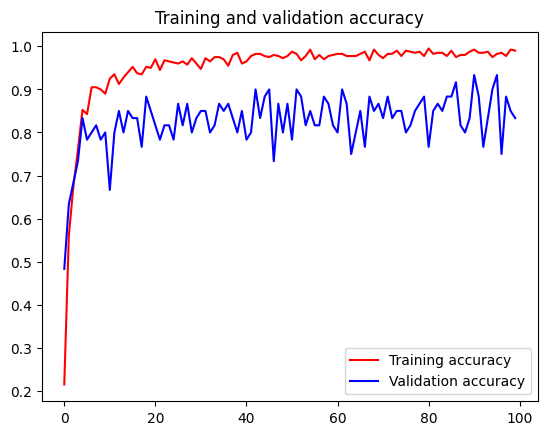

<Figure size 640x480 with 0 Axes>

In [111]:
# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Apesar de poucas imagens para treinamento, o modelo apresentou uma acuracidade satisfatória.

In [112]:
acc[-1], val_acc[-1]

(0.9900000095367432, 0.8333333134651184)

Aplicando o modelo a um caso prático, utilizo o imagem em LIBRAS do Avião.

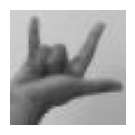

In [113]:
fname = 'Aviao.png'
libras_symbol = os.path.join(test_dir, fname)
img = mpimg.imread(libras_symbol)
plt.figure(figsize=(1.5,1.5))
plt.imshow(img)
plt.axis('Off')

plt.show()

In [114]:
img = load_img(libras_symbol, target_size=(75, 75))

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
image = np.vstack([x])

classes = model.predict(image)
#print(fn)
print(classes)

1/1 [==============================] - 1s 1s/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.2752499e-28 0.0000000e+00 1.0000000e+00 4.9005080e-25
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]


Modelo interpreta de forma correta a imagem.

In [115]:
predicted_class_indices=np.argmax(classes,axis=1)+1
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = labels[predicted_class_indices[0]]
prediction

'Aviao'

Bom, tentando melhorar o modelo, vou utilizar uma técnica conhecida como **Transfer Learning**, o conceito do Transfer Learning baseia-se em utilizar um modelo já treinado com centenas de milhares de imagens, adpatando e treinando sobre nossa necessidade. No caso abaixo, vou utilizar o model da IMAGENET (image-net.org).

In [116]:
# Set the weights file you downloaded into a variable
local_weights_file = '/content/model_inception.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (75, 75, 3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [118]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 768)


In [119]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(40, activation='softmax')(x)


# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv2d_288 (Conv2D)            (None, 37, 37, 32)   864         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 37, 37, 32)  96          ['conv2d_288[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_282 (Activation)    (None, 37, 37, 32)   0           ['batch_normalization_282[0

In [120]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [121]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (75, 75))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( VALIDATION_DIR,
                                                          batch_size  = 20,
                                                          class_mode  = 'categorical',
                                                          target_size = (75, 75))

Found 3179 images belonging to 40 classes.
Found 1593 images belonging to 40 classes.


In [122]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 11s - loss: 1.7877 - accuracy: 0.5730 - val_loss: 0.8092 - val_accuracy: 0.7710 - 11s/epoch - 108ms/step
Epoch 2/20
100/100 - 4s - loss: 0.4758 - accuracy: 0.8794 - val_loss: 0.5810 - val_accuracy: 0.8040 - 4s/epoch - 45ms/step
Epoch 3/20
100/100 - 6s - loss: 0.2504 - accuracy: 0.9360 - val_loss: 0.7966 - val_accuracy: 0.7790 - 6s/epoch - 61ms/step
Epoch 4/20
100/100 - 5s - loss: 0.1849 - accuracy: 0.9585 - val_loss: 0.6324 - val_accuracy: 0.8420 - 5s/epoch - 52ms/step
Epoch 5/20
100/100 - 6s - loss: 0.1545 - accuracy: 0.9605 - val_loss: 0.7347 - val_accuracy: 0.8010 - 6s/epoch - 58ms/step
Epoch 6/20
100/100 - 5s - loss: 0.1294 - accuracy: 0.9600 - val_loss: 0.7176 - val_accuracy: 0.8030 - 5s/epoch - 52ms/step
Epoch 7/20
100/100 - 5s - loss: 0.1187 - accuracy: 0.9625 - val_loss: 0.5571 - val_accuracy: 0.8360 - 5s/epoch - 47ms/step
Epoch 8/20
100/100 - 6s - loss: 0.0979 - accuracy: 0.9665 - val_loss: 0.6523 - val_accuracy: 0.8140 - 6s/epoch - 63ms/step
Epoch 9/20
10

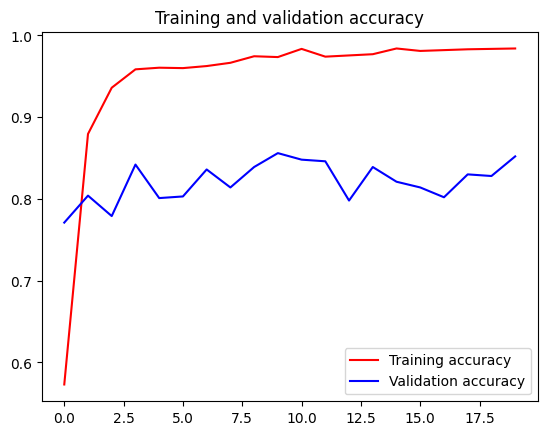

<Figure size 640x480 with 0 Axes>

In [123]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [124]:
acc[-1], val_acc[-1]

(0.984000027179718, 0.8519999980926514)

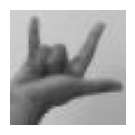

In [125]:
fname = 'Aviao.png'
libras_symbol = os.path.join(test_dir, fname)
img = mpimg.imread(libras_symbol)
plt.figure(figsize=(1.5,1.5))
plt.imshow(img)
plt.axis('Off')

plt.show()

In [126]:
img = load_img(libras_symbol, target_size=(75, 75))

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
image = np.vstack([x])

classes = model.predict(image)
#print(fn)
print(classes)

1/1 [==============================] - 1s 901ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [127]:
predicted_class_indices=np.argmax(classes,axis=1)
labels = (validation_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = labels[predicted_class_indices[0]]
prediction

'Adulto'